# Sensitivity Analysis

Having explained the basics of the model in four other notebooks, we now want to know which assumptions or inputs are most responsible for variations in outcomes. If the model is very sensitive to unknown and unimportant modeling parameters, it may be of little value, whereas if the number of predicted excess deaths depends on the amount of food and how it is distributed among the population, it may be of some practical use.

Here we look at a simple example of sensitivity analysis that considers variation in five input parameters:
1. `grain_multiplier`: What if the amount of available food was up to 10% more than baseline projections (corresponding to a 6x increase in food aid, or greater harvest results, etc.)
2. `factor_deficit`: part of the equation for modeling how caloric deficit affects BMI (see the `update_bmi` function in `model_utils.py`)
3. `factor_adj`: also part of the equation for modeling how caloric deficit affects BMI
4. `beta1`: the (slope) amount of inequality in the distribution of food: see `linear_distribution` in `model_utils.py`
5. `distrib_kcal_min`: the minimum amount of daily kcal distributed to any group (see `linear_distribution` in `model_utils.py`)

The results suggest the greatest influence is for the supply of food, followed by the equality of the food distribution. However, setting a minimum quantity of calories has little effect (NB that the minimum is not set to a sufficient number of calories, so ultimately the poorest of the poor still end up with inadequate nutrition.)

We look at first-order and total-order Sobol indices, and also plot the pairwise scatter plots. For more details on the method, see [Saltelli, et al. 2007. Global sensitivity analysis: a primer](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725184)

For the SALib package, see [the documentation here](https://salib.readthedocs.io/en/latest/)

In [1]:

import os
import re
import json
from pathlib import Path
import math
import warnings

import pandas as pd
import numpy as np


from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

#from SALib.sample import latin
from SALib.sample import sobol # older versions -from SALib.sample import saltelli


try: # identify if in colab to fix paths
    import google.colab
    IN_COLAB = True
    print("colab identified.")
except ImportError:
    IN_COLAB = False

In [ ]:
# clone the repository to access the data

!git clone https://github.com/aristotle-tek/famine-prediction.git


In [ ]:
if IN_COLAB: # fix for paths in colab
    base_path = Path('/content/famine-prediction')
else:
    try:
        base_path = Path(__file__).resolve().parent.parent
    except NameError:
        base_path = Path.cwd().parent.parent
print("Base path: ", base_path)

In [3]:
os.chdir(base_path)
from src.models import ResourceScarcityModel
from src.model_utils import load_config

In [4]:
# load config file, and define ranges for parameters we will vary.
config_path = base_path / 'config' / 'config_01.json'

config = load_config(config_path)


num_vars = 5

problem = {
    'num_vars': num_vars,
    'names': ['grain_multiplier', 'factor_deficit', 'factor_adj', 'beta1', 'min_kcal'],
    'bounds': [
        [0.9, 1.15],    # grain_multiplier
        [0.085, 0.10], # factor_deficit (0.091)
        [2.5, 3.5],    # factor_adj (3.41316)
        [0.5, 6.0],   # beta1 - inequality of distrib
        [600, 1000],  # min_kcal (grain)
    ]
}

# Sobol sampling
We will generate samples from these ranges.

In [ ]:

sim_results_path = base_path / 'sims'

os.makedirs(sim_results_path, exist_ok=True)

plots_folder =  base_path / 'plots'
os.makedirs(plots_folder, exist_ok=True)

desired_N = 32 # Results were presented with 128

# Some calculations to make sure have the required size of samples
def is_power_of_two(n):
    return (n != 0) and (n & (n - 1) == 0)

# Function to find the next power of 2
def next_power_of_two(n):
    return 1 if n == 0 else 2**(math.ceil(math.log2(n)))


# Verify if desired_N is a power of 2
if not is_power_of_two(desired_N):
    adjusted_N = next_power_of_two(desired_N)
    print(f"Warning: Desired base sample size N = {desired_N} is not a power of 2.")
    print(f"Adjusting N to the next power of 2: N = {adjusted_N}")
    N = adjusted_N
else:
    N = desired_N

# Calculate total runs based on N and number of parameters
D = problem['num_vars']
total_runs = N * (2 * D + 2)
print(f"Base Sample Size (N): {N}")
print(f"Total Number of Runs: {total_runs}")


# Generate samples using the Sobol sampler
param_values = sobol.sample(problem, N, calc_second_order=True)


Base Sample Size (N): 32
Total Number of Runs: 384


# Simply loop over parameter combinations, update the config each time by overwriting those values

In [ ]:
# NB: This is computationally somewhat intensive, e.g. roughly 5m for 384 runs.
results_list = []

errs = []
for i, params in enumerate(param_values):
    grain_multiplier = params[0]
    factor_deficit = params[1]
    factor_adj = params[2]
    beta1 = params[3]
    min_kcal = params[4]
    
    # Update config with these values
    config_run = config.copy()
    config_run['grain_multiplier'] = grain_multiplier
    config_run['factor_deficit'] = factor_deficit
    config_run['factor_adj'] = factor_adj
    config_run['distrib_beta1'] = beta1
    config_run['distrib_kcal_min'] = min_kcal
    # init and run the model
    scarcityModel = ResourceScarcityModel(config_run)
    scarcityModel.run_simulation()
    results = scarcityModel.get_results()
    
    # Collect outputs, for now just total deaths
    total_deaths = results['total_deaths_excess_mortality'].sum()
    total_deaths_year1 = results['total_deaths_excess_mortality'][:12].sum()
    total_deaths_year2 = results['total_deaths_excess_mortality'][12:24].sum()
    results_list.append({
        'grain_multiplier': grain_multiplier,
        'factor_deficit': factor_deficit,
        'factor_adj': factor_adj,
        'beta1': beta1,
        'min_kcal': min_kcal,
        'excess_deaths': total_deaths,
        'excess_deaths_year1': total_deaths_year1,
        'excess_deaths_year2': total_deaths_year2
    })
    
    # (optional) save detailed results for each run
    #path_for_saving = sim_results_path / f'run_{i}_detailed.csv'
    #results.to_csv(path_for_saving, index=False)

In [8]:

results_df = pd.DataFrame(results_list)
results_file = sim_results_path / 'sensitivity_analysis_results.csv'
results_df.to_csv(results_file, index=False)



In [16]:
# Let's compare the results for the simulations where
# there is a 5% or more increase in aid vs. those with 
# less than 5% increase:
#results_df.excess_deaths.median()
more_aid = results_df[results_df.grain_multiplier>1.05].excess_deaths.median()
less_aid = results_df[results_df.grain_multiplier<1.05].excess_deaths.median()

print("5-10 pct increase in aid, median excess deaths: ", str(int(np.floor(more_aid))))
print("0-5 pct increase in aid, median excess deaths: ", str(int(np.floor(less_aid))))

5-10 pct increase in aid, median excess deaths:  4047448
0-5 pct increase in aid, median excess deaths:  8848602


In [ ]:
from SALib.analyze import sobol

warnings.filterwarnings("ignore", category=FutureWarning)

Y = results_df['excess_deaths'].values
# bootstrap sample to get CIs:
Si = sobol.analyze(problem, Y, calc_second_order=True, conf_level=0.95, num_resamples=1000)
total_Si, first_Si, second_Si = Si.to_df()
print(first_Si)
print(total_Si)

                        S1   S1_conf
grain_multiplier  0.701884  0.341597
factor_deficit    0.033278  0.061231
factor_adj        0.134871  0.142849
beta1             0.170871  0.203261
min_kcal          0.002275  0.006194
                        ST   ST_conf
grain_multiplier  0.689483  0.304388
factor_deficit    0.014239  0.009764
factor_adj        0.065303  0.038502
beta1             0.173844  0.083483
min_kcal          0.000126  0.000098


In [ ]:
## The built in plotting function works, but it's not pretty:
#axes = Si.plot() #  returns matplotlib axes objects to allow later adjustment.
#plt.tight_layout()
#plt.show()

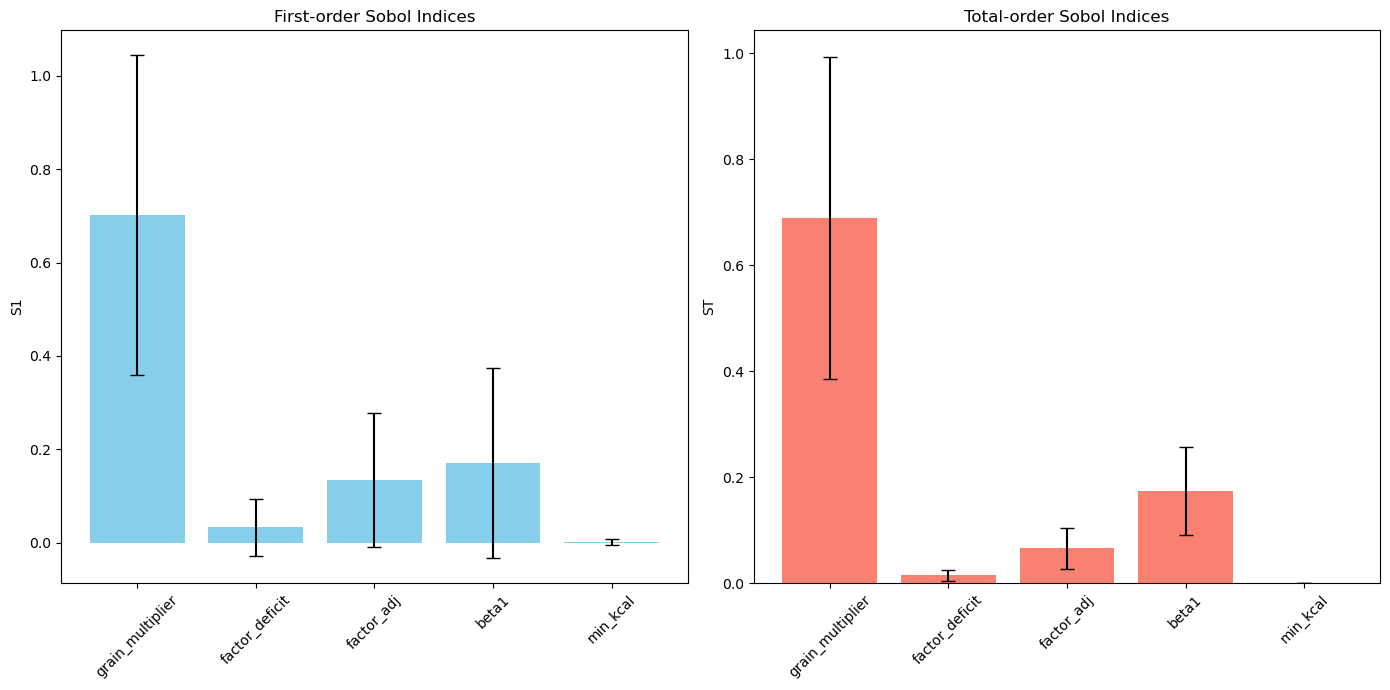

In [24]:
# slightly nicer plot:
first_Si = pd.DataFrame({
    'Parameter': problem['names'],
    'S1': Si['S1'],
    'S1_conf': Si['S1_conf']
})

total_Si = pd.DataFrame({
    'Parameter': problem['names'],
    'ST': Si['ST'],
    'ST_conf': Si['ST_conf']
})

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# 1st-order indices
axes[0].bar(first_Si['Parameter'], first_Si['S1'], yerr=first_Si['S1_conf'], capsize=5, color='skyblue')
axes[0].set_title('First-order Sobol Indices')
axes[0].set_ylabel('S1')
axes[0].tick_params(axis='x', rotation=45)

# Total-order indices
axes[1].bar(total_Si['Parameter'], total_Si['ST'], yerr=total_Si['ST_conf'], capsize=5, color='salmon')
axes[1].set_title('Total-order Sobol Indices')
axes[1].set_ylabel('ST')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Scatterplots
Another way to interpret the relationships is to look at the pairwise scatterplots of inputs and outputs. If a variable is uninfluential, the plot will just look like a generic cloud, while a strong relationship can be seen for example in the plot for 'grain_multiplier' (increase in food supply by up to 10%), in the first column, third row from the bottom.
(cf. [Saltelli, et al. 2007](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725184) p.22)

Note that while the analysis is conducted for total excess mortality, I also output the number of excess deaths in the first and second years, and these show up in the scatterplots.

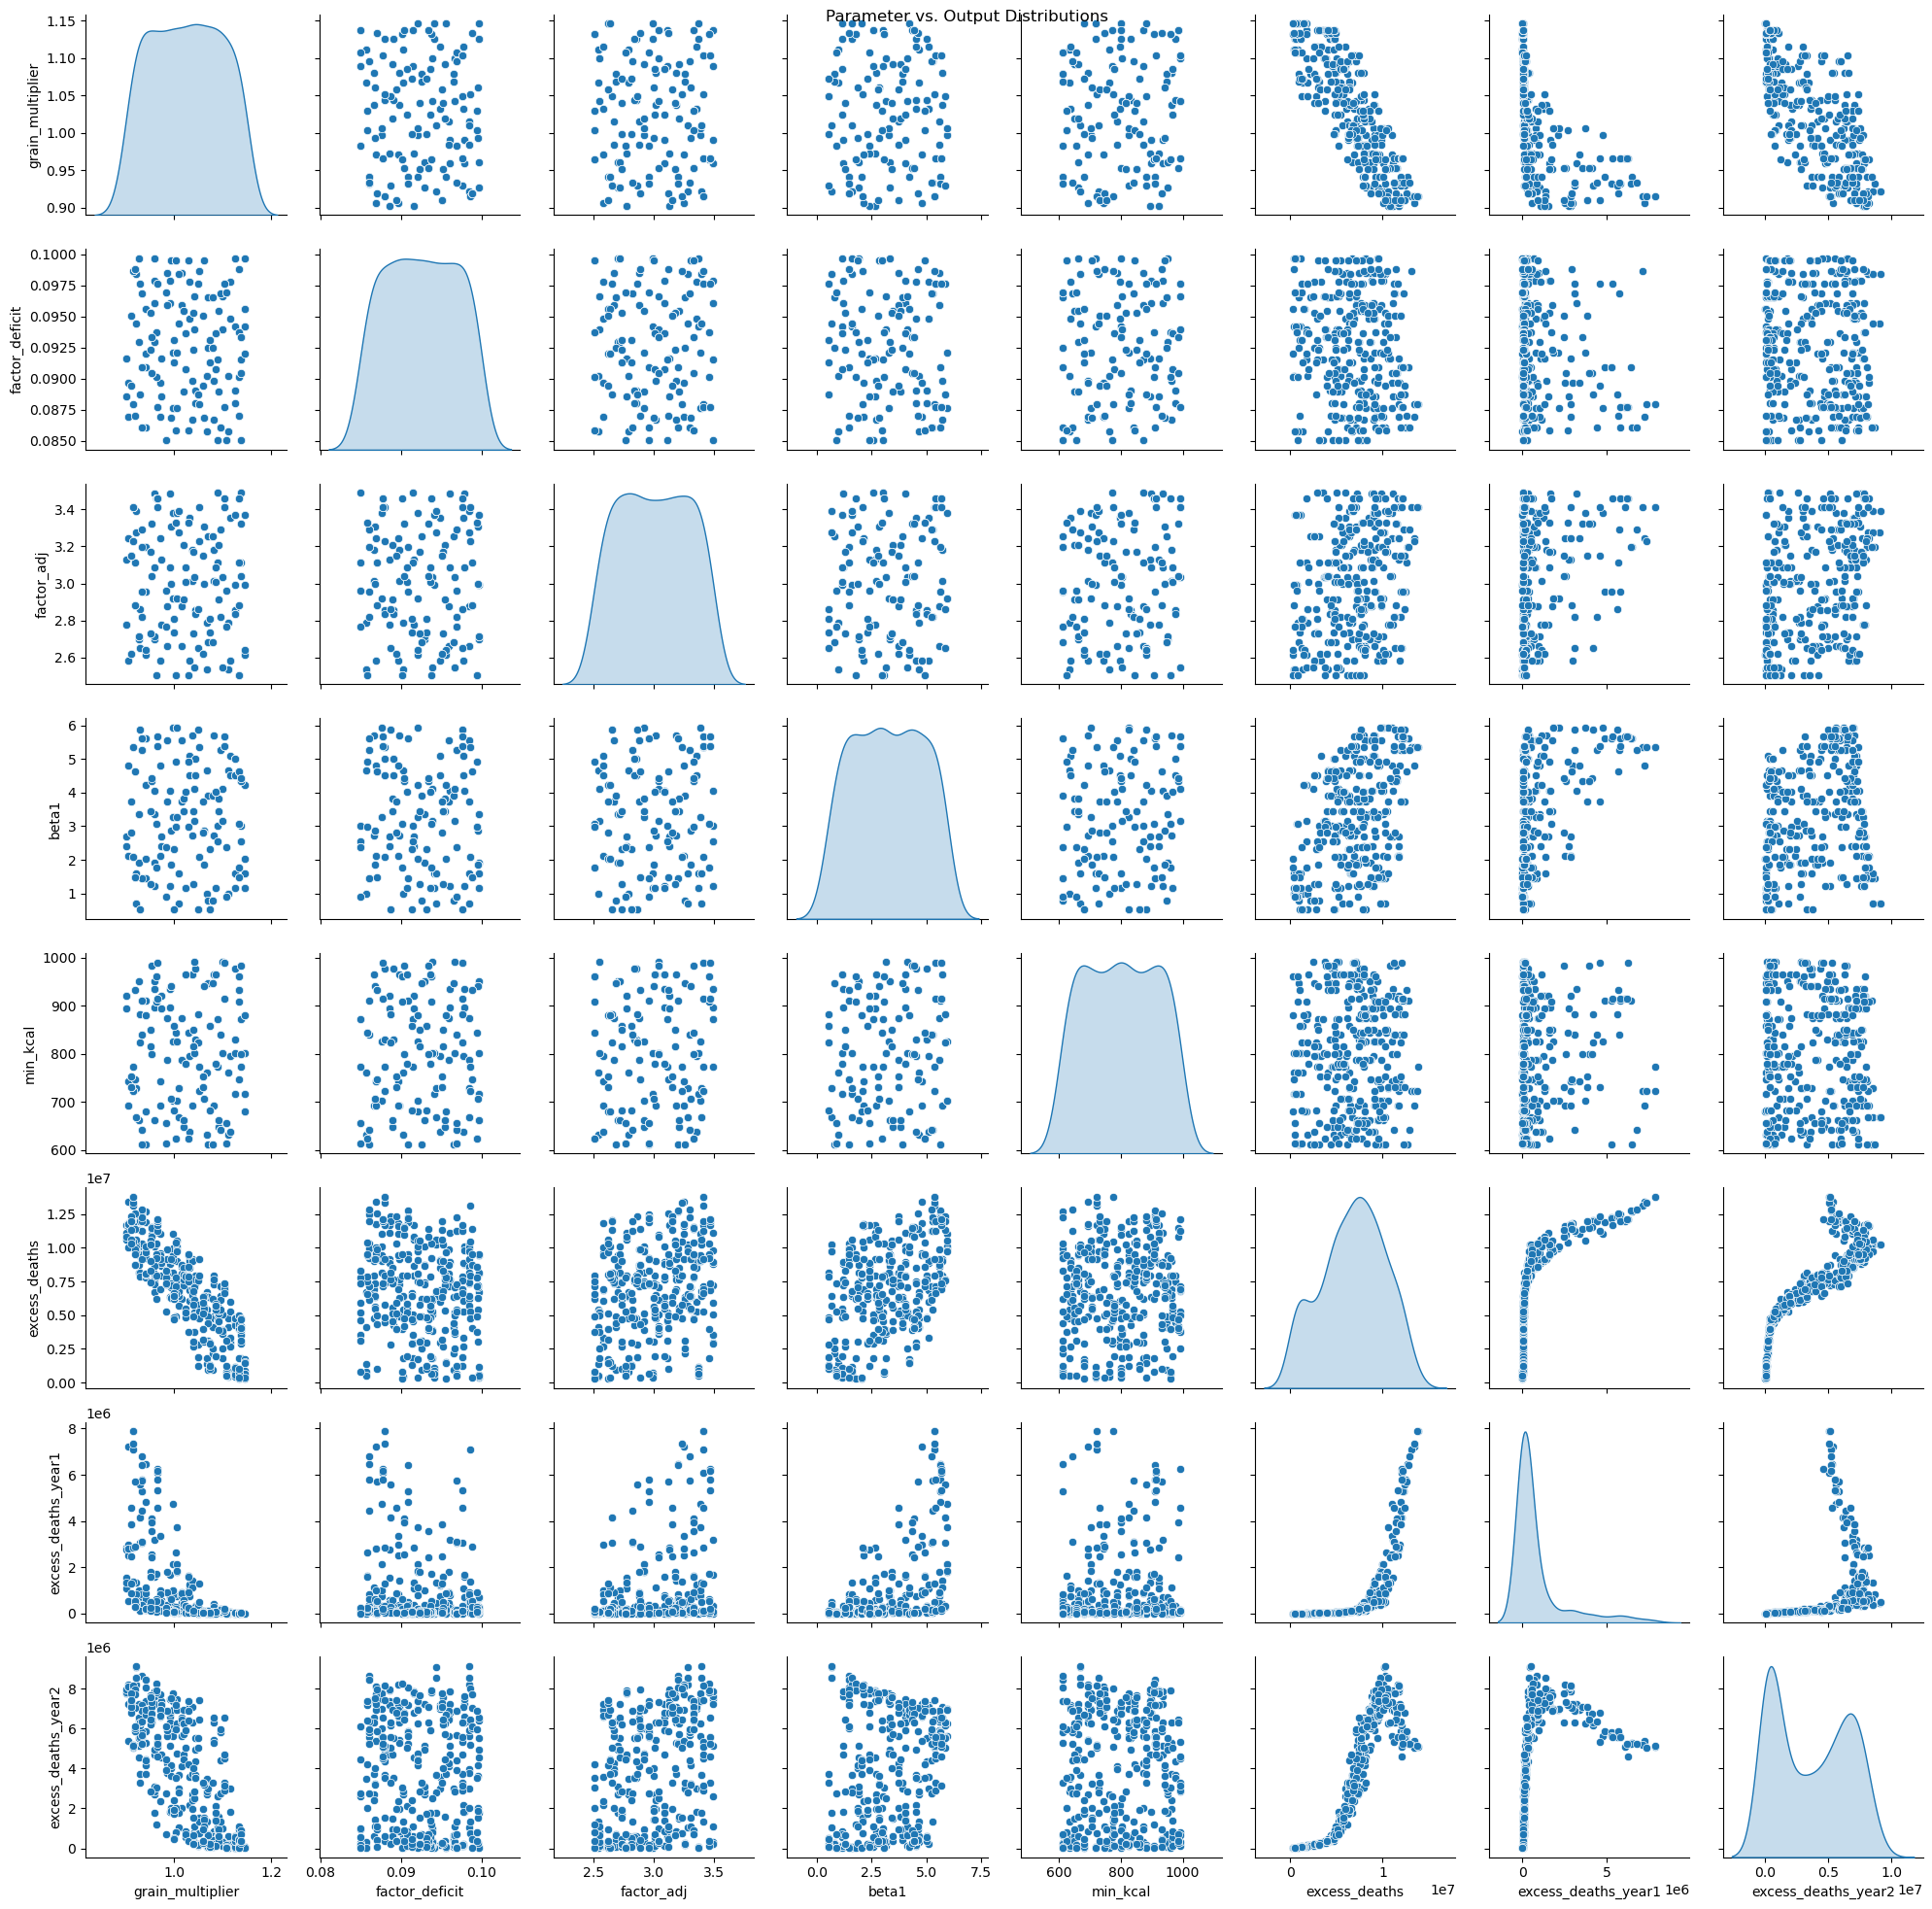

In [23]:
import seaborn as sns

sns.pairplot(results_df, diag_kind="kde")
plt.suptitle("Parameter vs. Output Distributions")
plt.tight_layout()
plt.show()